#### How to process Skagerak data

In [2]:
# load the modules that we will need
import pandas as pd
from scipy.interpolate import griddata
import xarray as xr
from glob import glob
%pylab inline

In [59]:
names = [
'Scan',
'Pressure',
'Temperature',
'Temperature2',
'Conductivity',
'Conductivity2',
'Oxygen raw',
'Oxygen raw2',
'Fluorescence',
'Turbidity',
'Depth',
'Salinity',
'Salinity2',
'Oxygen_pr',
'Oxygen_pr2', 
'flag']

In [167]:
# all the ctd files that we want to look at 
dataPath = '/Users/marcel/Downloads/ctd_mar440/ctd_data_day1/'
flist = sorted(glob(dataPath+'*ctm_fil_le_der_avg.cnv'))
flist

['/Users/marcel/Downloads/ctd_mar440/ctd_data_day1/Station 1 210921_ctm_fil_le_der_avg.cnv',
 '/Users/marcel/Downloads/ctd_mar440/ctd_data_day1/Station 1 ex 210921_ctm_fil_le_der_avg.cnv',
 '/Users/marcel/Downloads/ctd_mar440/ctd_data_day1/Station 2 210921_ctm_fil_le_der_avg.cnv',
 '/Users/marcel/Downloads/ctd_mar440/ctd_data_day1/Station 2ex 210921_ctm_fil_le_der_avg.cnv',
 '/Users/marcel/Downloads/ctd_mar440/ctd_data_day1/Station 3 210921_ctm_fil_le_der_avg.cnv',
 '/Users/marcel/Downloads/ctd_mar440/ctd_data_day1/Station 3ex 210921_ctm_fil_le_der_avg.cnv',
 '/Users/marcel/Downloads/ctd_mar440/ctd_data_day1/Station 4 210921_ctm_fil_le_der_avg.cnv',
 '/Users/marcel/Downloads/ctd_mar440/ctd_data_day1/Station 4ex 210921_ctm_fil_le_der_avg.cnv',
 '/Users/marcel/Downloads/ctd_mar440/ctd_data_day1/Station 5 210921_ctm_fil_le_der_avg.cnv',
 '/Users/marcel/Downloads/ctd_mar440/ctd_data_day1/Station 6 210921_ctm_fil_le_der_avg.cnv']

Ok, now we have listed and sorted the data files of all the CTD profiles that we want to read. Next we will create arrays of the data by first reading each station file in, then gridding to a common depth and then concatenating each profiles so that we end up with a 2D array of each variable that we are interested in.

#### We making arrays of the data along the same depth grid

In [221]:
dpt_new = np.arange(0, 61, 1) # we make a new depth to grid the data to

# step 1, lets create empty arrays of each variable we want
temperature  = np.ndarray([len(dpt_new), len(flist)])
salinity     = np.ndarray([len(dpt_new), len(flist)])
fluorescence = np.ndarray([len(dpt_new), len(flist)])
oxygen_pr    = np.ndarray([len(dpt_new), len(flist)])
# turbidity    = np.ndarray([len(flist), len(dpt_new)])

# now we loop through all the CTD files that we are interested in and concatenate to a common grid
for i, file in enumerate(flist):
    
    st = pd.read_csv(file, skiprows=325, delimiter='\s+', header=None, names=names)
    print(st['Depth'].max())
    st = st.drop(columns=['flag', 
                          'Scan', 
                          'Pressure', 
                          'Temperature2', 
                          'Conductivity', 
                          'Conductivity2', 
                          'Turbidity', 
                          'Oxygen_pr2', 
                          'Salinity2', 
                          'Oxygen raw', 
                          'Oxygen raw2']) # we drop the data variables that we don't want to use, these can be added by commenting the variable out 
    
    # ok, now we grid the data to a new depth grid called dpt_new
    temperature[:,i]  = griddata(st['Depth'].values, st['Temperature'],  dpt_new)
    salinity[:,i]     = griddata(st['Depth'].values, st['Salinity'],     dpt_new)
    fluorescence[:,i] = griddata(st['Depth'].values, st['Fluorescence'], dpt_new)
    oxygen_pr[:,i]    = griddata(st['Depth'].values, st['Oxygen_pr'],    dpt_new)
#     turbidity[i]    = griddata(st['Depth'], st['Turbidity'],    dpt_new)
        

14.0
30.0
43.0
24.0
20.0
11.0
10.0
42.0
24.0
33.0


#### Assign lat and lons

Here, you will fill in the lats and lons for each of the stations that you use in order of the station number in `flist` above

In [222]:
lat = [55.12,
       55.22,
       55.32,
       55.42,
       55.52,
       55.62,
       55.72,
       55.82,
       55.92,
       56.02]

lon = [11.02,
       11.12,
       11.22,
       11.32,
       11.42,
       11.52,
       11.62,
       11.72,
       11.82,
       11.92]

# this neat little trick allows you to define each station by where it was
fjord = ['Byfjord',
         'Byfjord',
         'Byfjord',
         'Byfjord',
        'Sill',
         'Sill',
        'Havstensfjord',
        'Havstensfjord',
        'Havstensfjord',
        'Havstensfjord']

In [223]:
import gsw
distance = np.append(0, cumsum(gsw.distance(lon, lat)))

Ok, now the magic begins, note that we use the coordinate for profile by choosing `fjord` and `depth` as now we can identify each profile by where it was, useful if you want to seperate these.

In [224]:
ds = xr.Dataset(

    data_vars=dict(

        temperature  =(["depth", "distance"], temperature),
        salinity     =(["depth", "distance"], salinity),
        fluorescence =(["depth", "distance"], fluorescence),
        oxygen_pr    =(["depth", "distance"], oxygen_pr),
#         turbidity    =(["fjord", "depth"], turbidity),
    ),

    coords=dict(

        station  =(["distance"], np.arange(1, 11, 1)),
        lon      =(["distance"], lon),
        lat      =(["distance"], lat),
        fjord    =(["distance"], fjord),
        distance =(["distance"], distance),
        depth    =(["depth"],    dpt_new)
    ),
    
    attrs=dict(description="MAR440 CTD data",
               ship='Skagerak',
               group='Group 2'
              )

)

In [225]:
ds

<xarray.Dataset>
Dimensions:       (depth: 61, distance: 10)
Coordinates:
    station       (distance) int64 1 2 3 4 5 6 7 8 9 10
    lon           (distance) float64 11.02 11.12 11.22 ... 11.72 11.82 11.92
    lat           (distance) float64 55.12 55.22 55.32 ... 55.82 55.92 56.02
    fjord         (distance) <U13 'Byfjord' 'Byfjord' ... 'Havstensfjord'
  * distance      (distance) float64 0.0 1.281e+04 ... 1.022e+05 1.15e+05
  * depth         (depth) int64 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59 60
Data variables:
    temperature   (depth, distance) float64 nan nan nan nan ... nan nan nan nan
    salinity      (depth, distance) float64 nan nan nan nan ... nan nan nan nan
    fluorescence  (depth, distance) float64 nan nan nan nan ... nan nan nan nan
    oxygen_pr     (depth, distance) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    description:  MAR440 CTD data
    ship:         Skagerak
    group:        Group 2

now you can play around with plotting the data 

/var/folders/n5/s6yw8y811f7bqlr9nb7w5rsr0000gn/T/ipykernel_66874/1430464551.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(ds['distance'], ds['depth'], ds['oxygen_pr'])


Text(0.0, 1.0, 'oxygen(ml/l)')

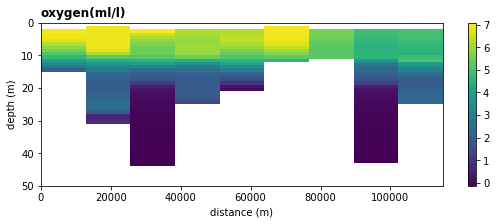

In [302]:
figure(figsize=[9,3])
pcolormesh(ds['distance'], ds['depth'], ds['oxygen_pr'])
colorbar()
ylim(50, 0)
xlabel('distance (m)')
ylabel('depth (m)')
title('oxygen(ml/l)', fontweight='bold', loc='left')

you can also select you data by fjord if you've named them, which is quite nice

In [308]:
len(ds_byfjord.distance)

4

Text(0.0, 1.0, 'byfjord profiles')

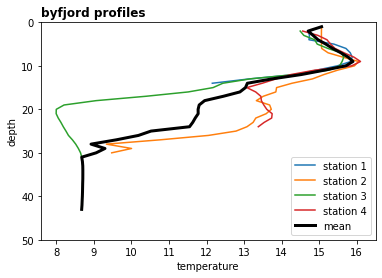

In [317]:
idx = ds['fjord']=='Byfjord'
ds_byfjord = ds.isel(distance=idx)

# iterate and plot the byfjord profiles
for i in range(len(ds_byfjord.distance)):
    
    plot(ds_byfjord.temperature[:,i], ds_byfjord.depth, label='station '+str(ds['station'][i].values))

# now plot the mean profile
plot(ds_byfjord.temperature.mean(dim='distance'), ds_byfjord.depth, lw=3, c='k', label='mean')

legend()

ylim(50, 0)
xlabel('temperature')
ylabel('depth')
title('byfjord profiles', loc='left', fontweight='bold')

we can also save this `xarray` dataset as a netcdf so we don't have to rerun it all the time

In [153]:
dataPath = '/Users/marcel/Desktop/'
filename = 'mar440_day1_ctds.nc'

ds.to_netcdf(dataPath+filename)

this is how you would load it in again

In [154]:
ds_loaded = xr.open_dataset('/Users/marcel/Desktop/mar440_day1_ctds.nc')

In [155]:
ds_loaded

<xarray.Dataset>
Dimensions:       (depth: 61, fjord: 10)
Coordinates:
    station       (fjord) int64 ...
    lon           (fjord) float64 ...
    lat           (fjord) float64 ...
  * fjord         (fjord) object 'Byfjord' 'Byfjord' ... 'Havstensfjord'
Dimensions without coordinates: depth
Data variables:
    temperature   (fjord, depth) float64 ...
    salinity      (fjord, depth) float64 ...
    fluorescence  (fjord, depth) float64 ...
    oxygen_pr     (fjord, depth) float64 ...
Attributes:
    description:  Sagerak day 1 ctd data